### Simple Data Loading

In [1]:
# Importing Libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# This is the needed transformation for the pretrained model
our_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 32

# Loading Data
dataset = datasets.ImageFolder('Data/Prostate Cancer',transform= our_transform)

# Splitting Data (70% Train, 30% Test)
train_set,test_set=th.utils.data.random_split(dataset,[0.7,0.3]) 

# Create data loaders
train_loader=th.utils.data.DataLoader(train_set,shuffle=True,batch_size=batch_size) 
test_loader=th.utils.data.DataLoader(test_set,batch_size=batch_size)  

# Print Data for Debugging
print("Categories: ",dataset.classes)
print("Number of Samples: ",len(dataset))
print("Number of Samples in Train Set: ",len(train_set))
print("Number of Samples in Test Set: ",len(test_set))

Categories:  ['gland', 'nongland', 'tumor']
Number of Samples:  6000
Number of Samples in Train Set:  4200
Number of Samples in Test Set:  1800


### Setting up CNN (ResNet 18)

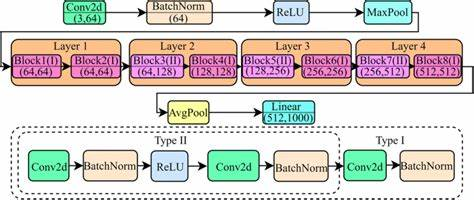

In [2]:
# The Basic Block (2 Convolutional Layers, Batch Normalization, ReLU Activation)
class BasicBlock (nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential() # This 
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
# Now to implement the ResNet 18 Model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Training Implementation

In [3]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Before Training, check if GPU is available and set the device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cuda


In [5]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
momentum = 0.9

model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Send data and model to device
model.to(device)
criterion.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch} loss: {running_loss / len(train_loader)}')


# Save the model to a file
th.save(model.state_dict(), 'resnet18.pth')

Epoch 0 loss: 0.36474860256368463
Epoch 1 loss: 0.16347854433468345
Epoch 2 loss: 0.12474428820706
Epoch 3 loss: 0.08938445289139495
Epoch 4 loss: 0.07096969647417692
Epoch 5 loss: 0.0631585937684797
Epoch 6 loss: 0.061275712819417204
Epoch 7 loss: 0.07296742883398
Epoch 8 loss: 0.09247626919496918
Epoch 9 loss: 0.07206256537006772
